In [1]:
import codecs
import os
import spacy
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from afinn import Afinn
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [2]:
def flatten(input_list):
    flat_list = []
    for i in input_list:
        if type(i) == list:
            flat_list += flatten(i)
        else:
            flat_list += [i]

    return flat_list

In [30]:
def common_words(path):
    with codecs.open(path) as f:
        words = f.read()
        words = json.loads(words)

    return set(words)

In [3]:
def read_novel(book_name, path):
    book_list = os.listdir(path)
    book_list = [i for i in book_list]
    novel = ''
    for i in book_list:
        with codecs.open(path / i, 'r', encoding='utf-8', errors='ignore') as f:
            data = f.read().replace('\r', ' ').replace('\n', ' ').replace("\'", "'")
        novel += ' ' + data

    return novel

In [4]:
def calculate_align_rate(sentence_list):
    afinn = Afinn()
    sentiment_score = [afinn.score(x) for x in sentence_list]
    align_rate = np.sum(sentiment_score)/len(np.nonzero(sentiment_score)[0]) * -2

    return align_rate, sentiment_score

In [5]:
def name_entity_recognition(sentence):
    doc = nlp(sentence)
    # retrieve person and organization's name from the sentence
    name_entity = [x for x in doc.ents if x.label_ in ['PERSON', 'ORG']]
    # convert all names to lowercase and remove 's in names
    name_entity = [str(x).lower().replace("'s","") for x in name_entity]
    # split names into single words ('Harry Potter' -> ['Harry', 'Potter'])
    name_entity = [x.split(' ') for x in name_entity]
    # flatten the name list
    name_entity = flatten(name_entity)
    # remove name words that are less than 3 letters to raise recognition accuracy
    name_entity = [x for x in name_entity if len(x) >= 3]
    # remove name words that are in the set of 4000 common words
    name_entity = [x for x in name_entity if x not in words]

    return name_entity

In [6]:
def iterative_NER(sentence_list, threshold_rate=0.0005):
    output = []
    for i in sentence_list:
        name_list = name_entity_recognition(i)
        if name_list != []:
            output.append(name_list)
    output = flatten(output)
    from collections import Counter
    output = Counter(output)
    output = [x for x in output if output[x] >= threshold_rate * len(sentence_list)]

    return output

In [7]:
def top_names(name_list, novel, top_num=20):
    vect = CountVectorizer(vocabulary=name_list, stop_words='english')
    name_frequency = vect.fit_transform([novel.lower()])
    name_frequency = pd.DataFrame(name_frequency.toarray(), columns=vect.get_feature_names())
    name_frequency = name_frequency.T
    name_frequency = name_frequency.sort_values(by=0, ascending=False)
    name_frequency = name_frequency[0:top_num]
    names = list(name_frequency.index)
    name_frequency = list(name_frequency[0])

    return name_frequency, names

In [8]:
def calculate_matrix(name_list, sentence_list, align_rate):
    afinn = Afinn()
    sentiment_score = [afinn.score(x) for x in sentence_list]
    # calculate occurrence matrix and sentiment matrix among the top characters
    name_vect = CountVectorizer(vocabulary=name_list, binary=True)
    occurrence_each_sentence = name_vect.fit_transform(sentence_list).toarray()
    cooccurrence_matrix = np.dot(occurrence_each_sentence.T, occurrence_each_sentence)
    sentiment_matrix = np.dot(occurrence_each_sentence.T, (occurrence_each_sentence.T * sentiment_score).T)
    sentiment_matrix += align_rate * cooccurrence_matrix
    cooccurrence_matrix = np.tril(cooccurrence_matrix)
    sentiment_matrix = np.tril(sentiment_matrix)
    # diagonals of the matrices are set to be 0 (co-occurrence of name itself is meaningless)
    shape = cooccurrence_matrix.shape[0]
    cooccurrence_matrix[[range(shape)], [range(shape)]] = 0
    sentiment_matrix[[range(shape)], [range(shape)]] = 0

    return cooccurrence_matrix, sentiment_matrix

In [9]:
def matrix_to_edge_list(matrix, mode, name_list):
    edge_list = []
    shape = matrix.shape[0]
    lower_tri_loc = list(zip(*np.where(np.triu(np.ones([shape, shape])) == 0)))
    normalized_matrix = matrix / np.max(np.abs(matrix))
    if mode == 'co-occurrence':
        weight = np.log(2000 * normalized_matrix + 1) * 0.7
        color = np.log(2000 * normalized_matrix + 1)
    if mode == 'sentiment':
        weight = np.log(np.abs(1000 * normalized_matrix) + 1) * 0.7
        color = 2000 * normalized_matrix
    for i in lower_tri_loc:
        edge_list.append((name_list[i[0]], name_list[i[1]], {'weight': weight[i], 'color': color[i]}))

    return edge_list

In [10]:
def plot_graph(name_list, name_frequency, matrix, plt_name, mode, path=''):
    label = {i: i for i in name_list}
    edge_list = matrix_to_edge_list(matrix, mode, name_list)
    normalized_frequency = np.array(name_frequency) / np.max(name_frequency)

    plt.figure(figsize=(20, 20))
    G = nx.Graph()
    G.add_nodes_from(name_list)
    G.add_edges_from(edge_list)
    pos = nx.circular_layout(G)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    colors = [G[u][v]['color'] for u, v in edges]

    if mode == 'co-occurrence':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000, edge_cmap=plt.cm.Blues,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True, width=weights)
    elif mode == 'sentiment':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True,
                width=weights, edge_vmin=-1000, edge_vmax=1000)
    else:
        raise ValueError("mode should be either 'co-occurrence' or 'sentiment'")

    plt.savefig(path + plt_name + '.png')

In [11]:
def zifs(novel, word_list, uwords):
    freq = [(i, word_list.count(i)) for i in uwords ]
    freq_df = pd.DataFrame(freq, columns=['type','freq'])
    freq_df.sort_values('freq',ascending = False, inplace=True)
    freq_df.reset_index(drop=True,inplace=True)
    freq_df.index+=1
    plt.plot(np.log(freq_df.index),np.log(freq_df.freq))
    plt.xlabel("Log(Rank)")
    plt.ylabel("Log(Frequency)")
    return world_list, uwords

In [12]:
def ARI(novel, words, sentences):
    char  = len(novel)
    word= len(words)
    sent  = len(sentences)
    ARI = 4.71*(char/word) + 0.5*(word/sent) - 21.43
    return ARI

In [31]:
nlp = spacy.load('en_core_web_sm')
words = common_words('common_words.txt')
novel_name = 'maha'
novel_folder = Path(os.getcwd())/'novels'
novel = read_novel(novel_name,novel_folder)

In [20]:
sentence_list = sent_tokenize(novel)
word_list = word_tokenize(novel)
uwords = set(word_list)

print("Total number of Characters :", len(novel))
print("Total number of words :", len(word_list))
print("Total unique words :", len(uwords))
print("Total number of sentecnes :", len(sentence_list))

Total number of Characters : 15186493
Total number of words : 3037333
Total unique words : 42101
Total number of sentecnes : 131618


In [ ]:
zifs(novel, word_list, uwords)

In [22]:
ari = ARI(novel,word_list,sentence_list)
print("ARI : ", ari)

ARI :  13.658174069936301


13 and above is for college students and professors .The ARI is coming close to that those can be read by professors.

In [23]:
align_rate, sentiment_score = calculate_align_rate(sentence_list)
print("Align Rate of the book :", align_rate)

Align Rate of the book : -2.2803761692761744


In [25]:
sentence_with_score = pd.DataFrame([(w, t) for w,t in zip(sentence_list, sentiment_score)],columns=['sent','score'])
pd.options.display.width = 0
sentence_with_score.head(20)

,sent,score
0,BOOK 1 ADI PARVA TRANSLATOR'S PREFACE The object of a translator should ever be to hold the mirror upto his author.,0.0
1,"That being so, his chief duty is to represent so far as practicable the manner in which his author's ideas have been expressed, retaining if possible at the sacrifice of idiom and taste all the peculiarities of his author's imagery and of language as well.",0.0
2,"In regard to translations from the Sanskrit, nothing is easier than to dish up Hindu ideas, so as to make them agreeable to English taste.",2.0
3,But the endeavour of the present translator has been to give in the following pages as literal a rendering as possible of the great work of Vyasa.,3.0
4,To the purely English reader there is much in the following pages that will strike as ridiculous.,-4.0
5,Those unacquainted with any language but their own are generally very exclusive in matters of taste.,3.0
6,"Having no knowledge of models other than what they meet with in their own tongue, the standard they have formed of purity and taste in composition must necessarily be a narrow one.",-1.0
7,"The translator, however, would ill-discharge his duty, if for the sake of avoiding ridicule, he sacrificed fidelity to the original.",-2.0
8,"He must represent his author as he is, not as he should be to please the narrow taste of those entirely unacquainted with him.",1.0
9,"Mr. Pickford, in the preface to his English translation of the Mahavira Charita, ably defends a close adherence to the original even at the sacrifice of idiom and taste against the claims of what has been called 'Free Translation,' which means dressing the author in an outlandish garb to please those to whom he is introduced.",2.0


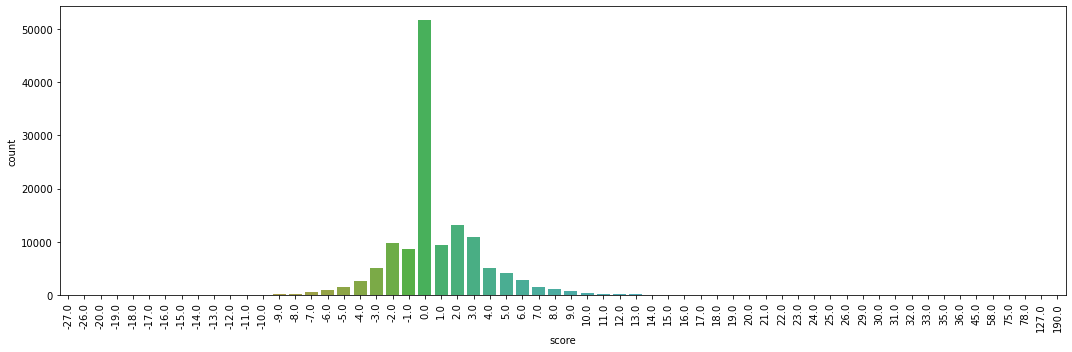

In [26]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='score', data=sentence_with_score)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

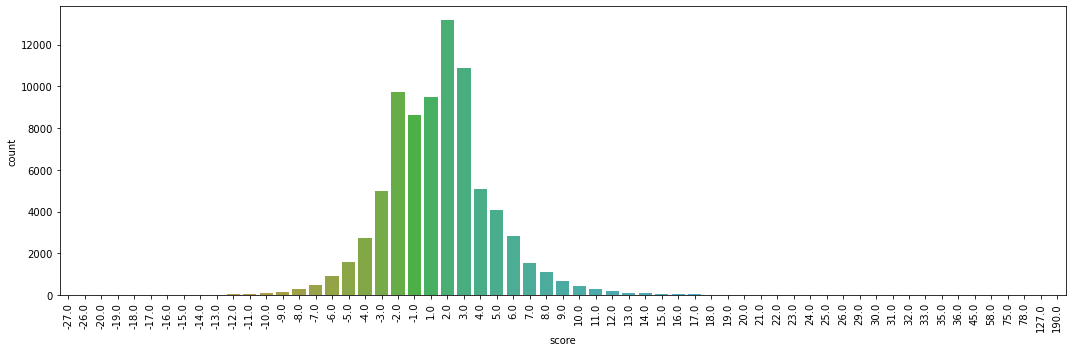

In [27]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='score', data=sentence_with_score.loc[(sentence_with_score['score'] != 0)])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [32]:
preliminary_name_list = iterative_NER(sentence_list, threshold_rate = 0.0001)

In [33]:
preliminary_name_list

['mahabharata',
 'sambhu',
 'sabha',
 'parva',
 'krishna',
 'santi',
 'pundits',
 'nilakantha',
 'vasudeva',
 'bharata',
 'sauti',
 'naimisha',
 'vaisampayana',
 'brahma',
 'puranas',
 'rishi',
 'dwaipayana',
 'hari',
 'sthanu',
 'daksha',
 'aswins',
 'sadhyas',
 'pisachas',
 'guhyakas',
 'pitris',
 'yugas',
 'devas',
 'bhanu',
 'yadus',
 'yayati',
 'yoga',
 'dharma',
 'kama',
 'astika',
 'veda',
 'vyasa',
 'adhyatma',
 'thou',
 'ganas',
 'suka',
 'pauloma',
 'bhishma',
 'vidura',
 'kuru',
 'narada',
 'rakshasas',
 'yudhishthira',
 'arjuna',
 'bhimasena',
 'kunti',
 'nakula',
 'sahadeva',
 'rajas',
 'rajasuya',
 'jarasandha',
 'duryodhana',
 'maya',
 'kripa',
 'kshatriyas',
 'vrishni',
 'indra',
 'khandava',
 'draupadi',
 'bhima',
 'duhsasana',
 'asuras',
 'pritha',
 'vaisravana',
 'yaksha',
 'matsya',
 'uttara',
 'santanu',
 'drona',
 'bharadwaja',
 'sikhandin',
 'maharathas',
 'saindhava',
 'yuyudhana',
 'kritavarma',
 'karna',
 'madhava',
 'rakshasa',
 'ghatotkacha',
 'dhristadyumna

In [34]:
name_frequency, name_list = top_names(preliminary_name_list, novel, 18)

In [35]:
top_name_freq = pd.DataFrame([(n,f) for n,f in zip(name_list,name_frequency)], columns = ['Name', 'Frequency'])

In [36]:
top_name_freq

,Name,Frequency
0,thou,16203
1,yudhishthira,3354
2,bharata,2942
3,arjuna,2931
4,brahmanas,2764
5,brahmana,2666
6,drona,2607
7,beholding,2567
8,karna,2472
9,bhishma,2405


In [37]:
cooccurrence_matrix, sentiment_matrix = calculate_matrix(name_list, sentence_list, align_rate)

In [38]:
print(sentiment_matrix.shape)
print(cooccurrence_matrix.shape)

(18, 18)
(18, 18)


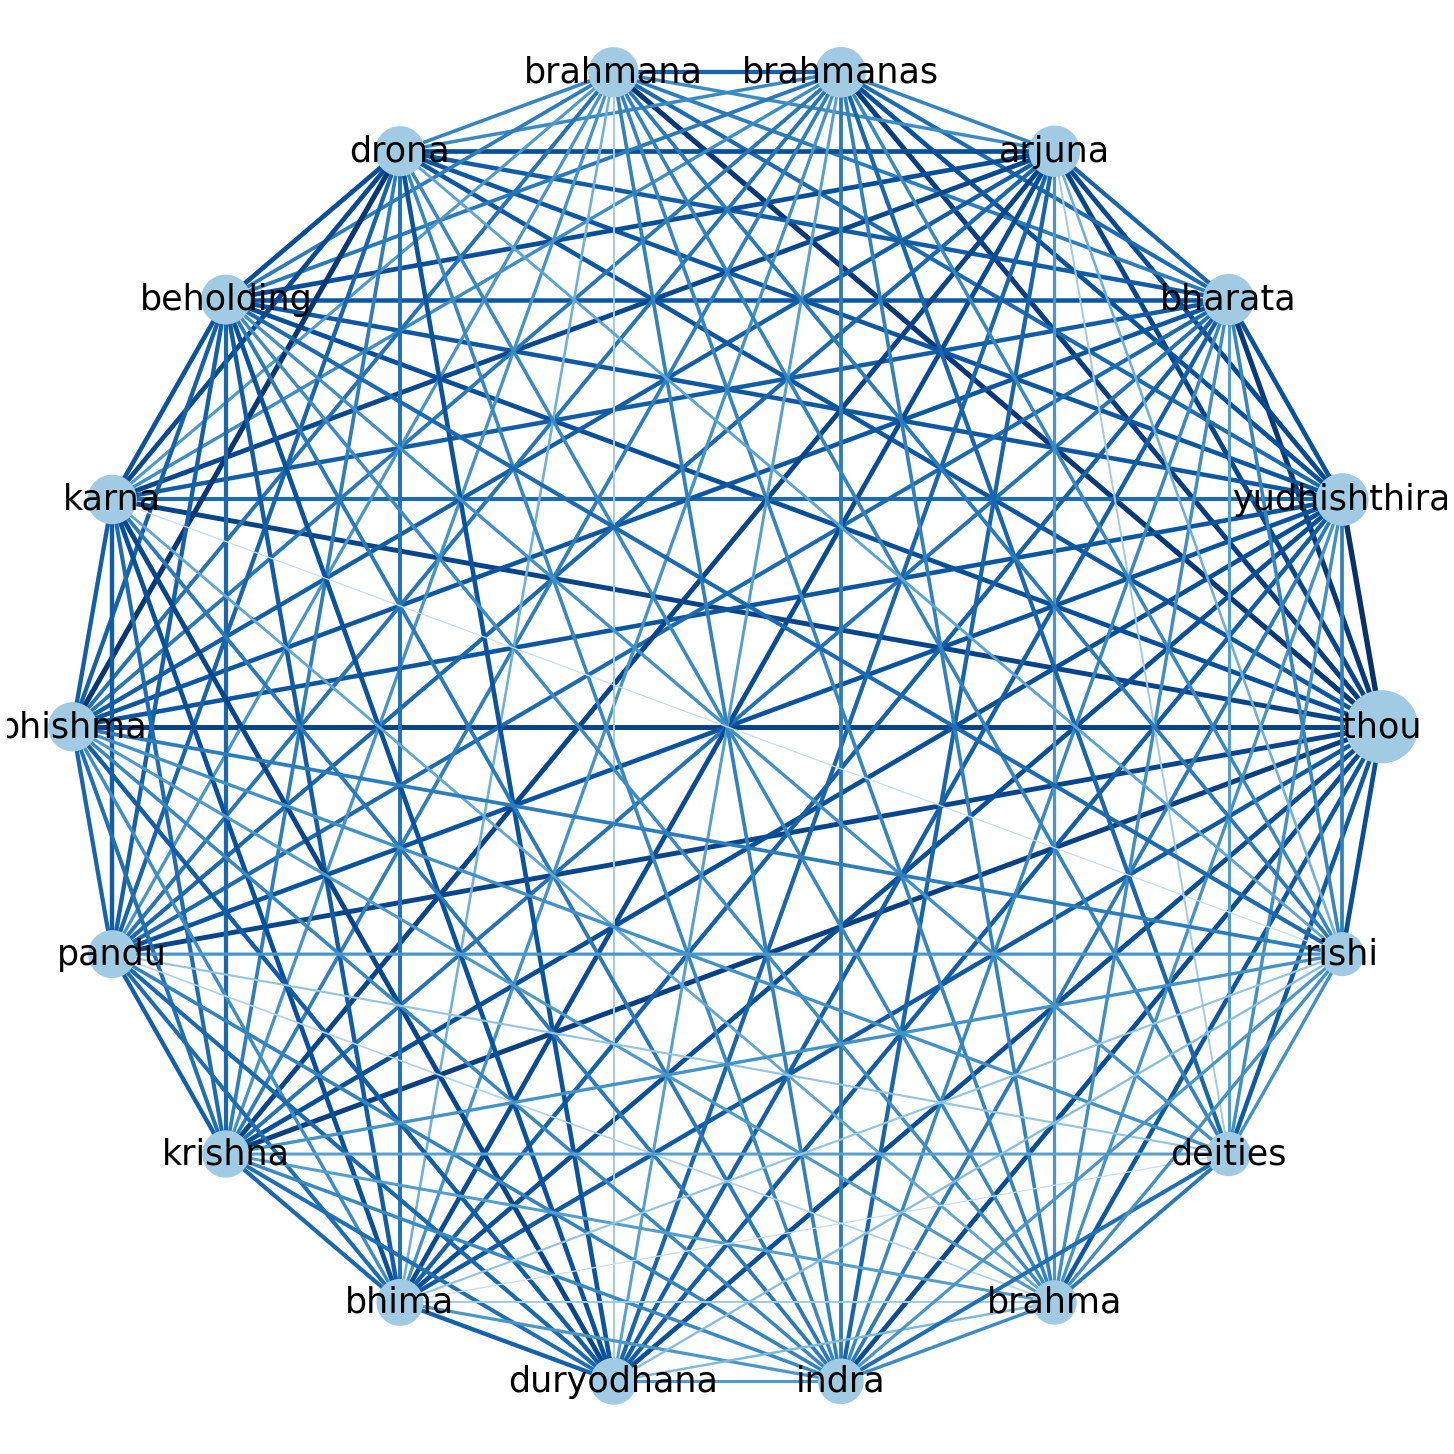

In [39]:
# plot co-occurrence and sentiment graph for Harry Potter
plot_graph(name_list, name_frequency, cooccurrence_matrix, novel_name + ' co-occurrence graph', 'co-occurrence')

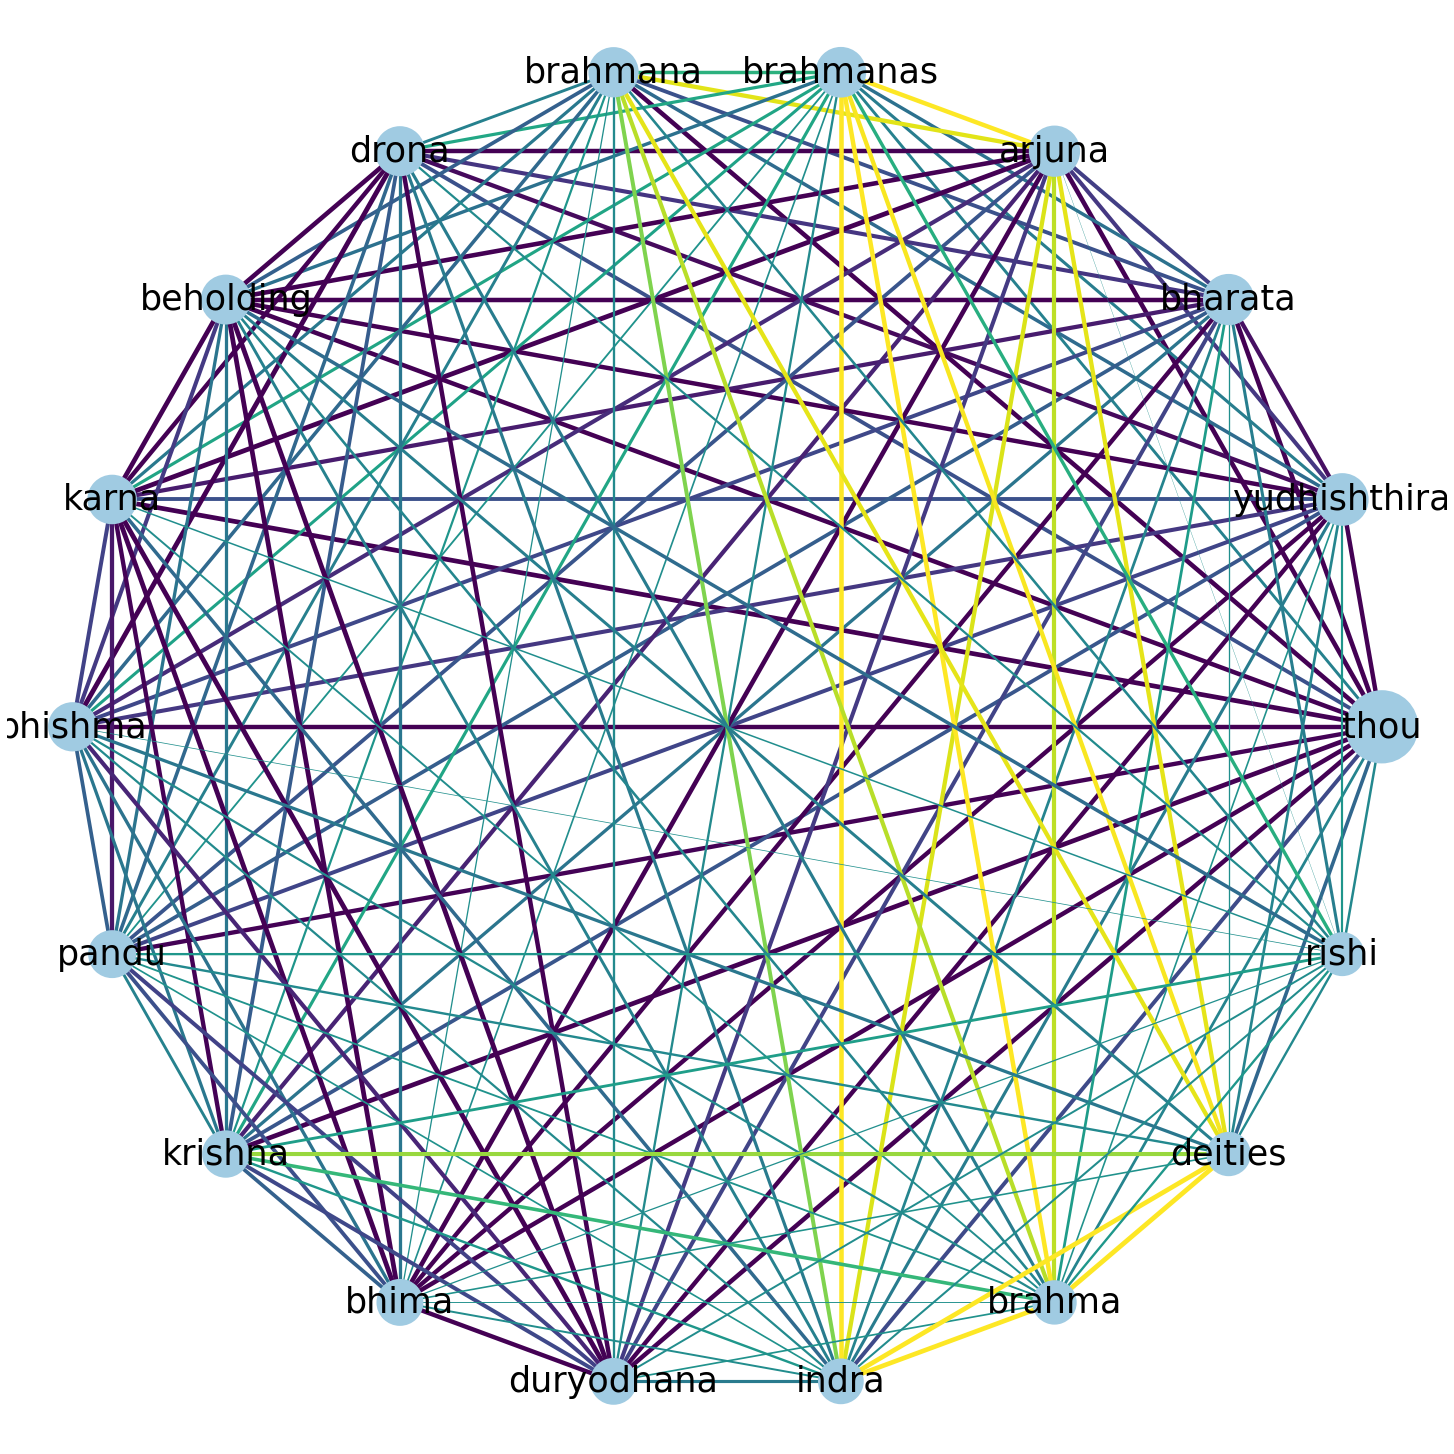

In [40]:
plot_graph(name_list, name_frequency, sentiment_matrix, novel_name + ' sentiment graph', 'sentiment')

In [41]:
from os import listdir
from os.path import isfile, join
novel_list = [f[:-4] for f in listdir('novels')]

In [ ]:
for name in novel_list:
    novel = read_novel(name, novel_folder)
    sentence_list = sent_tokenize(novel)
    cooccurrence_matrix, sentiment_matrix = calculate_matrix(name_list, sentence_list, align_rate)
    plot_graph(name_list, name_frequency, cooccurrence_matrix, name + ' co-occurrence graph', 'co-occurrence')
    plot_graph(name_list, name_frequency, sentiment_matrix, name + ' sentiment graph', 'sentiment')